### Outlier Factors for Device Profiling

From https://csr.lanl.gov/data/cyber1/ the flows.txt file is originally used

Each line is a individual event based on he format:

"time,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count"

In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('D:/Sotiris/Projects/diploma/multi-source-syber-security-events/flows_10000_lines.txt', header=None)

For this example all 

In [3]:
df.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


We need to group by time and source comuter name

In the final application, due to the streaming nature of the data, only a group by on the filed of source computer will be needed

In [7]:
# keep track of the different host
import numpy as np

hosts = np.array(list(set(df['source computer'].values)))

In [8]:
import numpy as np

# Create buckets based on the time of the events, a bucker for every size_of_bin_seconds seconds
size_of_bin_seconds = 50
bins = np.arange(df.index.min(), df.index.max() + size_of_bin_seconds, size_of_bin_seconds)
print('The borders of the bins created: ', bins)

The borders of the bins created:  [  1  51 101 151 201 251 301 351 401]


In [9]:
#groups = df[['byte count']].groupby(np.digitize(df.index, bins))

In [10]:
#number_of_flows = [i for [i]  in groups.count().values]
#avg_bytes_sent = [i for [i] in groups.mean().values]

In [11]:

# plot results only for the 10 random hosts
# choose 10 random hosts to plot results
num_of_random_hosts = 10

random_hosts = hosts[np.random.choice(len(hosts), num_of_random_hosts)]


df_for_random_hosts = df[df['source computer'].isin(random_hosts)]

groups = df_for_random_hosts[['byte count','source computer']].groupby([np.digitize(df_for_random_hosts.index, bins),'source computer'])

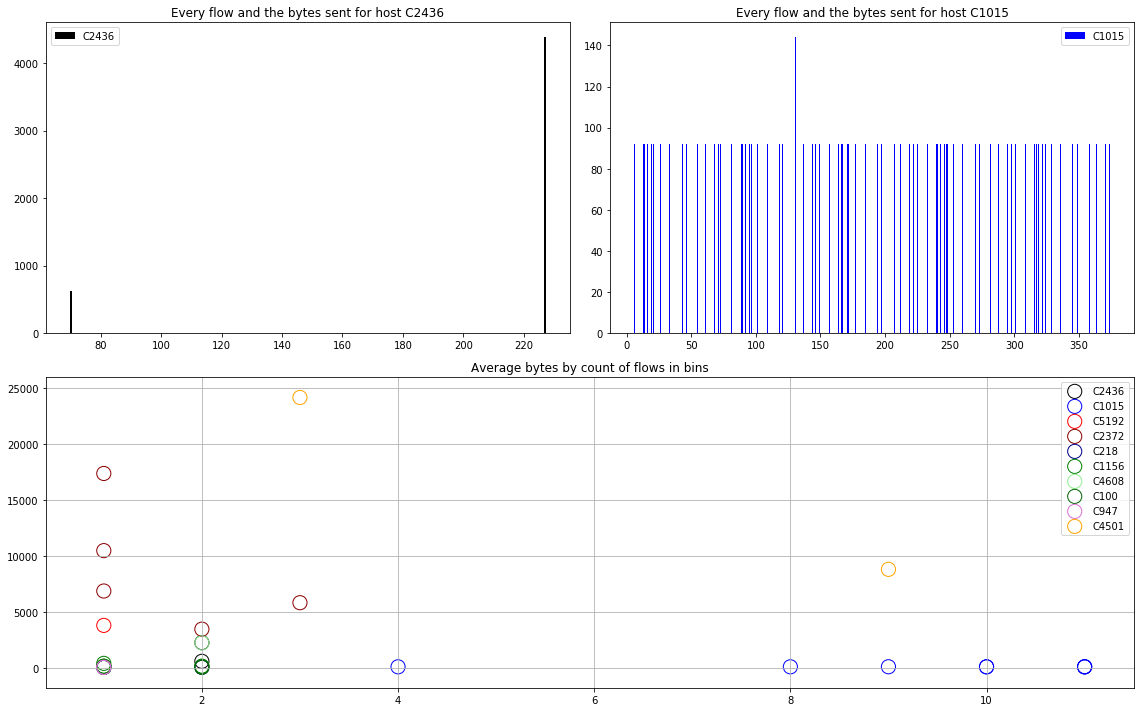

In [14]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

colors = ['black', 'blue', 'red', 'darkred', 'darkblue', 'green', 'lightgreen', 'darkgreen', 'orchid', 'orange']

mean_values = groups.mean().values
count_values = groups.count().values
"""
plt.subplot(2, 1, 1)

for i in range(num_of_random_hosts):
    df_for_host = df_for_random_hosts[df_for_random_hosts['source computer'].isin([random_hosts[i]])]
    plt.bar(df_for_host.index, df_for_host['byte count'], label=random_hosts[i], color=colors[i % len(colors)])

    
plt.title('Every flow and the bytes sent')
plt.legend()
"""

for i in range(2):
    plt.subplot(2, 2, i + 1)

    df_for_host = df_for_random_hosts[df_for_random_hosts['source computer'].isin([random_hosts[i]])]
    plt.bar(df_for_host.index, df_for_host['byte count'], label=random_hosts[i], color=colors[i % len(colors)])

    plt.title('Every flow and the bytes sent for host ' + random_hosts[i])
    plt.legend()

plt.subplot(2, 1, 2)

for i in range(num_of_random_hosts):
    filter_list = test = [x for x in groups.apply(lambda x:  (x['source computer'] == random_hosts[i]).values[0])]
    
    plt.scatter(count_values[filter_list], mean_values[filter_list], s=200, facecolors='none', 
                edgecolors=colors[i % len(colors)], label=random_hosts[i])
    
plt.title('Average bytes by count of flows in bins')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


For the following example we are considering only the bytes sent attribute

In [15]:
groups = df[['byte count','source computer']].groupby([np.digitize(df.index, bins),'source computer'])

In [16]:
data = groups.mean()
data.columns = ['mean(byte count)']
data['number of flows'] = groups.count().values

data.head()

mean(byte count)  number of flows
  source computer                                   
1 C1015                   92.000000               10
  C1056                   46.000000                2
  C1065                 1252.222222                9
  C113                   152.000000                1
  C1135                   52.000000                1

Preprecess the data according to a standard scaler

Should (0, 0) values be included in this preprocessing

In [17]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(data.values)
# μέση τιμη και απόκλιση του train set (δεν έχουμε εφαρμόση το scaling) 
print(scaler.mean_ , scaler.scale_ )

[  2.81082396e+04   3.62713094e+00] [  2.79275446e+05   1.33513483e+01]


In [ ]:
data_by_host = {}

for host in hosts:
    for i in range(len(bins) - 1):
        try:
            values = scaler.transform([data.loc[(i + 1, host)].values])
        except:
            values = np.array([[0, 0]])
        if i == 0:
            data_by_host[host] = values
        else:
            data_by_host[host] = np.append(data_by_host[host], values, axis=0)

In [ ]:
# how many different source computers to plot
number_plot_source_computers = 3

markers = ['v', 'x', '.', 's', 'p']

# the shrinkage
shrinkage = 0.5

i = 0
means = []
for host, data_for_host in data_by_host.items():
    # two features used
    x = data_for_host[:,0]
    y = data_for_host[:,1]
    plt.scatter(x, y, marker=markers[i % len(markers)], s=150, color='black', label='Host' + str(i + 1))
    mean_x = sum(x)/len(x)
    mean_y = sum(y)/len(y)
    means.append([mean_x, mean_y])
    
    plt.scatter(mean_x, mean_y, marker=markers[i % len(markers)], s=150, color='red', label='Avg' + str(i + 1))
    i += 1
    if i == number_plot_source_computers:
        break

global_mean = [float(sum(col))/len(col) for col in zip(*means)]

plt.scatter(global_mean[0], global_mean[1], marker='*', s=150, color='blue', label='Avg total')

i = 0
for mean in means:
    if i == 0:
        plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', label='Shrinking', color='pink')
    else:
        plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', color='pink')
    i += 1

i = 0
for mean in means:
    shrinked = np.array(mean) * (1 - shrinkage) + np.array(global_mean) * shrinkage
    plt.scatter(shrinked[0], shrinked[1], marker=markers[i % len(markers)], s=150, color='pink', label='Host' + str(i + 1))
    i += 1

plt.legend()

plt.show()